## California Housing in PyTorch

#### An example from `https://machinelearningmastery.com`

**Building a Regression Model in PyTorch**

> https://machinelearningmastery.com/building-a-regression-model-in-pytorch/

MSE: 0.29
RMSE: 0.54


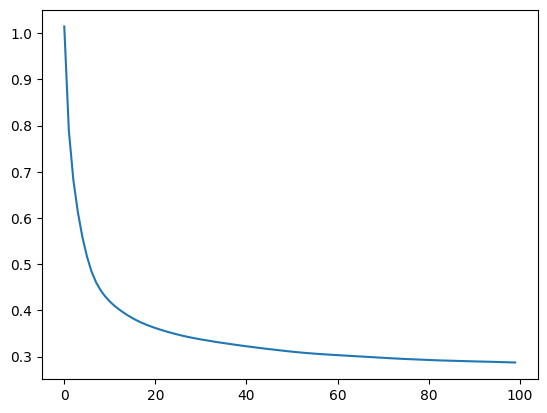

In [173]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler

# Read data
data = fetch_california_housing()
X, y = data.data, data.target

# train-test split for model evaluation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True)

# Standardizing data
scaler = StandardScaler()
scaler.fit(X_train_raw)
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

# Convert to 2D PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

# Define the model
model = nn.Sequential(
    nn.Linear(8, 24),
    nn.ReLU(),
    nn.Linear(24, 12),
    nn.ReLU(),
    nn.Linear(12, 6),
    nn.ReLU(),
    nn.Linear(6, 1)
)

# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 100   # number of epochs to run
batch_size = 10  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)

# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []

for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())

# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.show()

In [177]:
model.eval()
with torch.no_grad():
    # Test out inference with 5 samples
    for i in range(5):
        X_sample = X_test_raw[i: i+1]
        X_sample = scaler.transform(X_sample)
        X_sample = torch.tensor(X_sample, dtype=torch.float32)
        y_pred = model(X_sample)
        print(f"Prediction: {y_pred[0].squeeze().numpy(): 0.2f} | True value: {y_test[i].squeeze().numpy(): 0.2f}")

Prediction:  1.62 | True value:  1.42
Prediction:  1.24 | True value:  1.36
Prediction:  1.17 | True value:  1.12
Prediction:  1.93 | True value:  1.68
Prediction:  1.42 | True value:  0.85
